In [3]:
import numpy as np
from scipy.sparse import coo_matrix, kron, identity, eye, csr_matrix, csc_matrix
from scipy.linalg import expm
from qutip import *
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import warnings
from random import randint
import time
from sklearn.metrics import mean_absolute_error

In [2]:
def global_interactions_model(w1, lam, cn):
    w2 = 1
    Jx = 1
    Jy = 1
    Jz = 0.0
    ts = 0.2
    tss = 0.2
    tse = 0.05

    HS1 = (-w1/2)*tensor(sigmaz(), qeye(2), qeye(2)) #Self Hamiltonian of Spin 1
    HS2 = (-w2/2)*tensor(qeye(2), sigmaz(), qeye(2)) #Self Hamiltonian of Spin 2
    HS1S2 = lam/2*(tensor(sigmax(), sigmax(), qeye(2))) #Interaction Hamiltonian for Spin 1 and Spin 2
    HS1E = (1/2) * (Jx*tensor(sigmax(), qeye(2), sigmax()) + Jy*tensor(sigmay(), qeye(2), sigmay()) + Jz*tensor(sigmaz(), qeye(2), sigmaz()))
    HS2E = (1/2) * (Jx*tensor(qeye(2), sigmax(), sigmax()) + Jy*tensor(qeye(2), sigmay(), sigmay()) + Jz*tensor(qeye(2), sigmaz(), sigmaz()))

    US = csc_matrix(expm(-1j * (HS1 + HS2) * ts))
    US1S2 = csc_matrix(expm(-1j * HS1S2 * tss))
    US1E = csc_matrix(expm(-1j * HS1E * tse))
    US2E = csc_matrix(expm(-1j * HS2E * tse))

    PsiSinitial = coo_matrix(np.kron([[np.cos(np.pi/4)], [np.sin(np.pi/4)]], 
                                     [[np.cos(np.pi/4)], [np.sin(np.pi/4)]]))

    RhoSinitial = PsiSinitial.dot(PsiSinitial.conjugate().transpose())
    rho_Einitial = np.array([[1., 0.], [0., 0.]])

    RhoS1 = [csc_matrix(np.zeros((2, 2))) for _ in range(cn + 1)]
    RhoS2 = [csc_matrix(np.zeros((2, 2))) for _ in range(cn + 1)]
    RhoS1S2 = [csc_matrix(np.zeros((4, 4))) for _ in range(cn + 1)]
    RhoE1E2 = [csc_matrix(np.zeros((4, 4))) for _ in range(cn + 1)]
    rho = [csc_matrix(np.zeros((4, 4))) for _ in range(cn + 1)]

    RhoS1[0] = Qobj(RhoSinitial, dims=[[2, 2], [2, 2]]).ptrace(1)
    RhoS2[0] = Qobj(RhoSinitial, dims=[[2, 2], [2, 2]]).ptrace(0)
    RhoS1S2[0] = RhoSinitial.toarray()
    RhoE1E2[0] = rho_Einitial
    rho[0] = RhoSinitial.toarray()

    for ii in range(cn):
        rho_rho = kron(rho[ii], rho_Einitial)
        rho_C = Qobj(US) * Qobj(US1S2) * Qobj(US2E) * Qobj(US1E) * Qobj(rho_rho) * Qobj(US1E).dag() * Qobj(US2E).dag() * Qobj(US1S2).dag() * Qobj(US).dag()
        rho_Sys1Sys2 = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace([0,1]).data.toarray()
        rho_Sys1 = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace(0).data.toarray()
        rho_Sys2 = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace(1).data.toarray()
        rho_SysEnv = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace([0,1]).data.toarray()
        RhoS1[ii+1] = Qobj(rho_Sys1/np.trace(rho_Sys1))
        RhoS2[ii+1] = Qobj(rho_Sys2/np.trace(rho_Sys2))
        RhoS1S2[ii+1] = Qobj(rho_Sys1Sys2/np.trace(rho_Sys1Sys2))
        rho[ii+1] = rho_SysEnv/np.trace(rho_SysEnv)

    ExpecXspin1 = [np.array(np.trace(RhoS1[kk] * sigmax())).astype(float) for kk in range(len(RhoS1))]
    ExpecXspin2 = [np.array(np.trace(RhoS2[jj] * sigmax())).astype(float) for jj in range(len(RhoS2))]
    
    
    return ExpecXspin1, ExpecXspin2

In [9]:
%%time
import time
tempoInicial = time.time()
dataGlobalModel = list()
for i in range(0, 76):
    w1=0.93 + (i/500)
    for j in range(0,51):
        print(i, time.time()-tempoInicial)
        lam = (j/500)
        ExpecXspin1, ExpecXspin2 = global_interactions_model(w1=w1, lam=lam, cn = 5000)
        dataGlobalModel.append([w1]+[lam]+ ExpecXspin1+ExpecXspin2)
dataGlobalModel = pd.DataFrame(dataGlobalModel)

0 2.8848648071289062e-05


/var/folders/f4/hx11lq_j6792tcjgw6ymn5kc0000gn/T/ipykernel_68558/2169738663.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  ExpecXspin1 = [np.array(np.trace(RhoS1[kk] * sigmax())).astype(float) for kk in range(len(RhoS1))]
/var/folders/f4/hx11lq_j6792tcjgw6ymn5kc0000gn/T/ipykernel_68558/2169738663.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  ExpecXspin2 = [np.array(np.trace(RhoS2[jj] * sigmax())).astype(float) for jj in range(len(RhoS2))]


0 15.769712924957275
0 30.947524070739746
0 45.897398948669434
0 61.0059928894043
0 75.89088892936707
0 91.21728301048279
0 106.06158208847046
0 120.89418005943298
0 135.88624095916748
0 150.78978085517883
0 165.60953903198242
0 181.02104592323303
0 196.57905387878418
0 212.1239469051361
0 227.34773302078247
0 242.32677912712097
0 257.3205187320709
0 272.2364659309387
0 287.1617970466614
0 302.2021291255951
0 317.1311318874359
0 332.1083598136902
0 346.9994411468506
0 362.4077379703522
0 377.4171118736267
0 392.37876081466675
0 407.29838585853577
0 422.4586601257324
0 437.4750258922577
0 452.43622279167175
0 467.3510329723358
0 482.6854000091553
0 497.9397118091583
0 512.8894999027252
0 528.0150179862976
0 543.1140270233154
0 558.3609809875488
0 573.6624701023102
0 588.7670609951019
0 603.7583327293396
0 618.7533349990845
0 633.9395439624786
0 648.8048439025879
0 663.7987859249115
0 678.7560329437256
0 693.7199957370758
0 708.6150677204132
0 723.7249457836151
0 738.6512448787689
0 753.

7 6743.257383823395
7 6759.942646026611
8 6776.410933971405
8 6792.661206960678
8 6809.628251075745
8 6825.755445957184
8 6841.895995140076
8 6858.020267963409
8 6874.218086004257
8 6890.429648160934
8 6906.803653001785
8 6923.049654960632
8 6939.5625948905945
8 6955.719300985336
8 6972.949190855026
8 6989.27535200119
8 7008.022500038147
8 7025.138777017593
8 7045.642129898071
8 7065.7791249752045
8 7082.577493906021
8 7104.8965039253235
8 7132.779521942139
8 7164.48924779892
8 7190.303548812866
8 7207.279536724091
8 7224.307821989059
8 7253.54036283493
8 7278.612593889236
8 7300.967983007431
8 7333.385369062424
8 7350.615664720535
8 7368.571783781052
8 7385.683881998062
8 7403.2020099163055
8 7421.428066968918
8 7438.9628469944
8 7457.836132049561
8 7476.569863796234
8 7493.242003917694
8 7509.966247797012
8 7526.58737206459
8 7543.3196358680725
8 7559.3931040763855
8 7575.953226804733
8 7593.275998830795
8 7611.53028178215
8 7628.932004928589
8 7648.847708940506
8 7665.53253698349
8 

15 13545.326762914658
15 13561.603925943375
15 13578.439074993134
15 13594.645648956299
15 13611.190756082535
15 13627.584155082703
15 13644.684710741043
15 13661.233140945435
15 13678.2337808609
15 13694.495807886124
15 13711.269179821014
15 13727.655653953552
15 13744.477391958237
15 13760.95546579361
15 13777.992286920547
15 13794.576206922531
15 13811.49529004097
15 13828.116881132126
15 13845.140196084976
15 13861.670814990997
15 13878.886425971985
15 13895.861521720886
16 13912.91994214058
16 13929.578882932663
16 13946.468016147614
16 13963.16519999504
16 13980.053854942322
16 13996.87490606308
16 14014.35192489624
16 14031.316982984543
16 14048.550471782684
16 14065.37723994255
16 14082.793141841888
16 14099.794512033463
16 14117.34693813324
16 14134.440198898315
16 14151.92859005928
16 14168.755474805832
16 14186.141979932785
16 14202.771152973175
16 14220.249727964401
16 14237.120742797852
16 14254.802057981491
16 14271.629680871964
16 14289.406206846237
16 14306.200575828552

22 20251.23295688629
23 20268.863430023193
23 20287.023633003235
23 20304.358319044113
23 20322.498651742935
23 20340.000101089478
23 20359.28985095024
23 20376.813747882843
23 20395.414965867996
23 20412.821661949158
23 20430.89303278923
23 20448.234305858612
23 20466.451655864716
23 20483.847917079926
23 20502.139385938644
23 20519.723649024963
23 20538.084617853165
23 20555.757035970688
23 20574.342170000076
23 20593.460469007492
23 20613.542979955673
23 20631.727730751038
23 20651.470885038376
23 20669.101540088654
23 20688.813539981842
23 20706.179062843323
23 20725.95692896843
23 20743.78994989395
23 20763.17017889023
23 20780.75579380989
23 20799.12830901146
23 20816.741473913193
23 20835.791536808014
23 20854.413638830185
23 20873.367654800415
23 20891.87237095833
23 20911.12109899521
23 20929.590256929398
23 20949.308079004288
23 20968.290157079697
23 20988.177855968475
23 21006.736134767532
23 21026.10871386528
23 21044.688334941864
23 21064.57094192505
23 21083.864511966705


30 27469.595299959183
30 27490.379224061966
30 27508.685611009598
30 27529.26112294197
30 27547.83786892891
30 27568.597327947617
30 27587.094472885132
30 27607.963491916656
30 27626.465605974197
30 27647.02111887932
30 27665.419173002243
30 27685.8505320549
30 27704.370728969574
30 27724.9978659153
30 27743.454402923584
30 27764.187014102936
30 27782.44899392128
30 27806.64608001709
30 27825.557167053223
30 27846.231348991394
30 27864.96656680107
30 27885.776292085648
30 27904.263214111328
30 27924.990753889084
30 27943.569586753845
30 27964.256807804108
30 27982.63734483719
30 28003.185532808304
30 28021.610904932022
30 28042.244889974594
31 28061.423316001892
31 28082.267016887665
31 28100.89447593689
31 28121.677330970764
31 28140.336253881454
31 28161.539801120758
31 28180.311505794525
31 28201.91344690323
31 28220.688836097717
31 28241.84398984909
31 28260.400968790054
31 28281.554206848145
31 28300.536881923676
31 28321.83060503006
31 28340.53176498413
31 28361.78427195549
31 28

37 35019.29812502861
37 35041.660621881485
37 35061.18277692795
37 35083.03970503807
37 35102.65350794792
38 35124.61194586754
38 35144.001879930496
38 35165.7469329834
38 35184.859745025635
38 35206.61229681969
38 35225.589978933334
38 35247.48082089424
38 35266.711753845215
38 35288.38062405586
38 35307.48123693466
38 35329.12090396881
38 35348.43577694893
38 35370.274393081665
38 35389.80475783348
38 35411.68516802788
38 35430.684952020645
38 35452.628944158554
38 35471.81937599182
38 35493.66414499283
38 35513.10874795914
38 35534.92596292496
38 35554.48280787468
38 35576.510640859604
38 35596.19150495529
38 35618.179523944855
38 35638.33109283447
38 35660.438796043396
38 35679.63379597664
38 35701.40613985062
38 35720.48745799065
38 35742.3343629837
38 35761.74508476257
38 35783.50736784935
38 35802.67602491379
38 35824.53088092804
38 35843.95256280899
38 35865.878479003906
38 35885.69360303879
38 35907.453553915024
38 35926.723417043686
38 35948.60070896149
38 35968.28763103485
3

45 43313.75045990944
45 43333.662220954895
45 43359.023034095764
45 43378.81991696358
45 43404.145606040955
45 43423.87126994133
45 43449.36215901375
45 43469.36373972893
45 43494.42382001877
45 43514.07395505905
45 43539.65385389328
45 43559.68438696861
45 43584.913898944855
45 43605.123672008514
45 43630.421962976456
45 43650.43815398216
45 43676.07981801033
45 43695.88084602356
45 43720.85849094391
45 43740.97328686714
45 43766.60790491104
45 43786.40622997284
45 43811.43662786484
45 43831.13030600548
45 43856.21861076355
45 43876.25634884834
46 43901.79039096832
46 43921.60059595108
46 43946.67904686928
46 43966.37324094772
46 43992.54950809479
46 44013.082407951355
46 44038.88484978676
46 44058.84686899185
46 44084.33411812782
46 44104.10768890381
46 44129.71497178078
46 44149.64711809158
46 44174.83841705322
46 44195.08507800102
46 44219.43142294884
46 44239.36546087265
46 44264.60203289986
46 44284.49702382088
46 44309.81917095184
46 44329.535632133484
46 44354.72180914879
46 44

53 52247.14172387123
53 52273.85040998459
53 52294.43031001091
53 52321.13382911682
53 52341.27819800377
53 52367.75566291809
53 52387.7870388031
53 52414.3490459919
53 52434.863273859024
53 52461.36051893234
53 52481.682879924774
53 52508.24380683899
53 52528.90950489044
53 52555.610116004944
53 52575.81645107269
53 52602.22040891647
53 52622.5801589489
53 52649.20571899414
53 52669.66005086899
53 52696.20172214508
53 52716.3748190403
53 52743.03671693802
53 52763.55223894119
53 52790.4172410965
53 52810.553945064545
53 52836.69758415222
53 52856.806467056274
53 52883.19040775299
53 52903.515494823456
53 52930.12056493759
53 52951.06582093239
53 52978.200222969055
53 52998.69697594643
53 53025.81648993492
53 53046.24655890465
53 53073.28863096237
53 53093.77394294739
53 53120.93295001984
53 53141.28981900215
53 53168.221673965454
53 53188.61023187637
53 53215.594770908356
53 53236.0415930748
53 53263.531974077225
53 53284.046662807465
53 53310.97476601601
53 53331.26626300812
54 53358

60 61278.686753988266
60 61299.361495018005
60 61324.13778710365
60 61344.85032892227
60 61369.43188095093
60 61390.25426888466
60 61415.473524808884
60 61435.97212576866
60 61460.64922785759
60 61481.14951014519
60 61506.02676796913
60 61526.84008002281
60 61552.145251989365
60 61572.942752838135
60 61597.71941590309
60 61618.27673602104
60 61643.32862210274
61 61664.16152596474
61 61689.03301978111
61 61709.944139003754
61 61735.50419974327
61 61757.53374004364
61 61784.14210987091
61 61804.945163965225
61 61830.21049594879
61 61850.866271972656
61 61878.95366382599
61 61906.27291584015
61 61935.46650481224
61 61957.886759757996
61 61983.622666835785
61 62005.64253306389
61 62032.718827962875
61 62054.89823675156
61 62084.03188300133
61 62105.397804021835
61 62141.42180085182
61 62164.95950293541
61 62197.579657793045
61 62221.28851509094
61 62253.89147686958
61 62281.74419283867
61 62309.10505580902
61 62330.3560590744
61 62354.965187072754
61 62375.45733499527
61 62400.073681116104

68 71019.92800688744
68 71046.21393680573
68 71067.54545593262
68 71093.25950789452
68 71114.29266786575
68 71140.38986110687
68 71161.32386398315
68 71187.42706608772
68 71208.41020488739
68 71234.26684212685
68 71255.67854189873
68 71282.0710530281
68 71303.75377893448
68 71330.64531707764
68 71351.94216275215
68 71378.39407777786
68 71399.76600909233
68 71425.52995991707
68 71446.66940307617
68 71473.14673304558
68 71495.24957895279
68 71521.75062584877
68 71542.86363887787
68 71568.60952281952
68 71589.79404783249
68 71615.99619603157
68 71637.44233894348
68 71663.64675593376
68 71684.65133404732
68 71710.5190141201
68 71731.66752886772
68 71757.3973209858
68 71778.51089787483
68 71804.39506983757
69 71825.26705408096
69 71852.93509292603
69 71884.1260459423
69 71920.66920685768
69 71946.2011950016
69 71978.51697397232
69 72003.1278450489
69 72033.31888198853
69 72057.28717589378
69 72088.10684204102
69 72112.8774998188
69 72143.32740879059
69 72166.90571594238
69 72197.39461898804

In [4]:
dataGlobalModel = pd.read_csv("dataGlobalModel_2.csv").drop("Unnamed: 0", axis=1)
dataGlobalModel

,0,1,2,3,4,5,6,7,8,9,...,9994,9995,9996,9997,9998,9999,10000,10001,10002,10003
0,0.93,0.000,1.0,0.981524,0.929275,0.845139,0.732094,0.594108,0.435996,0.263257,...,0.001229,0.001439,0.001590,0.001675,0.001692,0.001640,0.001521,0.001342,0.001109,0.000832
1,0.93,0.002,1.0,0.981523,0.929274,0.845138,0.732091,0.594102,0.435988,0.263247,...,0.000941,0.001111,0.001233,0.001304,0.001320,0.001283,0.001193,0.001054,0.000873,0.000658
2,0.93,0.004,1.0,0.981523,0.929274,0.845136,0.732088,0.594097,0.435981,0.263237,...,0.000706,0.000827,0.000912,0.000958,0.000963,0.000928,0.000854,0.000744,0.000604,0.000439
3,0.93,0.006,1.0,0.981523,0.929273,0.845134,0.732085,0.594093,0.435975,0.263229,...,0.000511,0.000577,0.000617,0.000629,0.000613,0.000570,0.000501,0.000411,0.000302,0.000180
4,0.93,0.008,1.0,0.981523,0.929272,0.845133,0.732082,0.594088,0.435968,0.263222,...,0.000354,0.000358,0.000345,0.000313,0.000266,0.000205,0.000132,0.000051,-0.000035,-0.000121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,1.08,0.092,1.0,0.975532,0.905831,0.794260,0.646134,0.468461,0.269615,0.058937,...,-0.061392,-0.045519,-0.027914,-0.009252,0.009753,0.028373,0.045895,0.061650,0.075036,0.085542
3872,1.08,0.094,1.0,0.975532,0.905831,0.794260,0.646136,0.468470,0.269637,0.058980,...,-0.098346,-0.093067,-0.084235,-0.072188,-0.057390,-0.040408,-0.021891,-0.002549,0.016879,0.035651
3873,1.08,0.096,1.0,0.975532,0.905830,0.794261,0.646139,0.468480,0.269660,0.059023,...,-0.087611,-0.096222,-0.101157,-0.102227,-0.099396,-0.092773,-0.082614,-0.069308,-0.053364,-0.035393
3874,1.08,0.098,1.0,0.975531,0.905830,0.794261,0.646142,0.468490,0.269683,0.059067,...,-0.031229,-0.050071,-0.066995,-0.081356,-0.092608,-0.100325,-0.104215,-0.104131,-0.100079,-0.092216


In [15]:
def mae_ml_global(data, meas=100):
    pc = list()
    for i in range(0, len(data)):
        pc.append(pearsonr(data.values[i, 4902:5003], data.values[i, 9903:])[0])
    X = list()
    for j in range(0, len(data)):
        l1 = list(data.values[j, 2:(2+meas)])
        l2 = list(data.values[j, 5003:(5003+meas)])
        X.append(l1+l2)
    X = pd.DataFrame(pd.DataFrame(X))
    
    X_train, X_test, y_train, y_test = train_test_split(X, pc, test_size=0.3)
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    prediction = knn.predict(X)
    prevision = knn.predict(X_test)
    
    mae = mean_absolute_error(prevision, y_test)
    print(mae)
    
    return mae, prediction, pc

def plot_Global(data, meas=100):
    ml = mae_ml_global(data, meas)
    knn = ml[1]
    pc = ml[2]
    cm = plt.cm.get_cmap('RdYlBu')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=2.0)
    plt1 = ax1.scatter(data["0"], data["1"], c=pc, cmap = cm, s=1000)
    plt2 = ax2.scatter(data["0"], data["1"], c=knn, cmap = cm, s=1000)
    ax1.title.set_text("Real Pearson Coefficient")
    ax1.set_xlim(0.93, 1.06)
    ax2.set_xlim(0.93, 1.06)
    ax2.title.set_text("Predicted Pearson Coefficient")
    fig.text(0.5, 0.04, r'$\omega_1/\omega_2$', ha='center')
    fig.text(-0.02, 0.5, r'$\lambda$', va='center', rotation='vertical')
    cbar_ax = fig.add_axes([1.00, 0.15, 0.02, 0.7])
    fig.colorbar(plt1, cax=cbar_ax)


0.059500273842831165


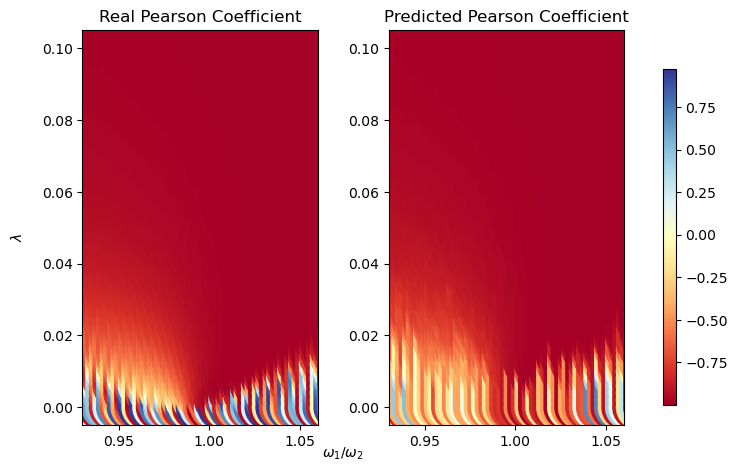

In [16]:
plot_Global(dataGlobalModel, meas=100)

## Noise

Adding error to the test data to see if the algorithm is still able to predict accurately the Pearson Coefficient.


In [40]:
def adding_Error(data, rand_error, meas):
    warnings.filterwarnings("ignore")
    error_data = data.copy()
    for i in range(2, meas+2):
        for j in range(0, len(error_data)):
            error_data["{}".format(i)][j] = error_data["{}".format(i)][j]+(rand_error*randint(-10,10)*0.1)
            error_data["{}".format(i+3001)][j] = error_data["{}".format(i+3001)][j]+(rand_error*randint(-10,10)*0.1)
    return error_data

def error_pearson_master(data, meas_vals, error_vals):
    mae_list_error = list()
    for i in meas_vals:
        for j in error_vals:
            print([i, j])
            mae_list_prov = list()
            mae_list_prov.append(i)
            mae_list_prov.append(j*100)
            mae_list_prov.append(mae_ml_global(data = adding_Error(data, rand_error = j, meas=i), meas=i)[0])
            mae_list_error.append(mae_list_prov)
    mae_list_error = pd.DataFrame(mae_list_error)
    
    return mae_list_error

def plot_pearson_error_master(mae_list_error, meas_vals):
    for i in meas_vals:
        plt.plot(mae_list_error[1][mae_list_error[0]==i], mae_list_error[2][mae_list_error[0]==i], label=i)
    plt.xlabel("Error added on the test data (%)")
    plt.ylabel("MAE (Mean Absolute Error)")
    plt.legend()
    plt.show()


In [23]:
%%time
mse_list_error_global = error_pearson_master(dataGlobalModel, [5, 10, 25, 50, 75, 100], [0, 0.001, 0.005, 0.008, 0.010, 0.015, 0.018, 0.02, 0.03, 0.04, 0.05])
mse_list_error_global.to_csv("mse_list_error_global.csv")

[5, 0]
0.05194505171177611
[5, 0.001]
0.23984420129414866
[5, 0.005]
0.23703720421368207
[5, 0.008]
0.23995359827839888
[5, 0.01]
0.25473730876807665
[5, 0.015]
0.2409904040253702
[5, 0.018]
0.24781783869858534
[5, 0.02]
0.24102040074958522
[5, 0.03]
0.25748598588101124
[5, 0.04]
0.2557873838975305
[5, 0.05]
0.2564230164359502
[10, 0]
0.058520883042442726
[10, 0.001]
0.21582285925848246
[10, 0.005]
0.2430033012763751
[10, 0.008]
0.2437696393670277
[10, 0.01]
0.2473235158457557
[10, 0.015]
0.2305180192338681
[10, 0.018]
0.23808311883642447
[10, 0.02]
0.24603812145083856
[10, 0.03]
0.24696440760644087
[10, 0.04]
0.2384424568930486
[10, 0.05]
0.2536967161275427
[25, 0]
0.06024507668235656
[25, 0.001]
0.06631832446900877
[25, 0.005]
0.13969191354287774
[25, 0.008]
0.16571885175575352
[25, 0.01]
0.17222443374960383
[25, 0.015]
0.1932505917173721
[25, 0.018]
0.2109730957778401
[25, 0.02]
0.21819865201857622
[25, 0.03]
0.2241348177168554
[25, 0.04]
0.23597721667424543
[25, 0.05]
0.23779852146

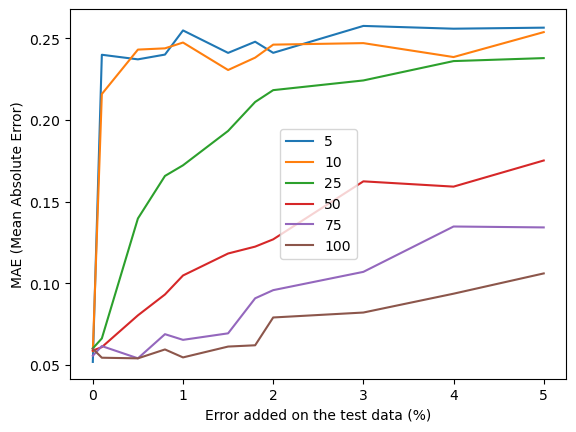

In [41]:
plot_pearson_error_master(mse_list_error_global, [5, 10, 25, 50, 75, 100])